Author: Kwok Keith
Date: 19 Jan 26

This notebook contains demonstrations of different mission parameters to spec a SAR payload for SPOTLIGHT mode. It is based off the following literature:

<b>Performance Limits for Synthetic Aperture Radar - second edition</b> by Armin W. Doerry (SAND2006-0821) <br>
Printed February 2006

In [11]:
from spot_mission import SpotMission
from mission_environment import EnvironmentParameters
from radar_signal import Signal
from satellite import Satellite
from phased_array import PhasedArray
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Variables that can be changed
# Below we define the baseline mission parameters (current)
centre_frequency_hz = 10e9          # Signal Carrier Frequency (X-band [10 - 12.4 GHz])
bandwidth_hz = 1.2e9                # Signal Bandwidth (Hz)
prf_hz = 4000.0                     # Signal PRF
pulse_width_us = 37.5               # Pulse Width in microseconds 
swath_m = 5000.0                    # Mission Swath Width in metres
integration_angle_deg = 30.0        # Integration Angle in deg
look_angle_from_nadir_deg = 20.0    # Look Angle from Nadir in degrees

satellite = Satellite(
    look_angle_from_nadir_deg=look_angle_from_nadir_deg,
    platform_velocity_mps=7000.0,    # Fixed for a LEO satellite
    orbit_altitude_m=580000.0,       # Fixed for mission (500km to 580km)
    radar_loss_db=5.0,               # Fixed for system
    receiver_noise_factor_db=4.0,    # Fixed for system
)
# Fixed
phased_array = PhasedArray(          
    num_width_elements=32,  
    num_height_elements=32,
    element_width_m=0.1,
    element_height_m=0.053125,
    element_power_w=3.125,
    antenna_efficiency=0.95,
)
signal = Signal(
    antenna=phased_array,
    centre_frequency_hz=centre_frequency_hz,
    bandwidth_hz=bandwidth_hz,
    prf_hz=prf_hz,
    pulse_width_us=pulse_width_us,
    range_processing_loss_db=0,    # Fixed
    azimuth_processing_loss_db=0,  # Fixed
    broadening_factor_azimuth=1.2, # Fixed
    broadening_factor_range=1.2,   # Fixed
    doppler_gain_constant=1.5,     # Fixed
)
# Fixed
environment_parameters = EnvironmentParameters( 
    nominal_temperature_k=300.0,
    two_way_atmospheric_loss_db=3.24e-06, # Changes with frequency and look angle
)

mission = SpotMission(
    swath_range_m=swath_m,
    swath_azimuth_m=swath_m,
    integration_angle_deg=integration_angle_deg,
# Fixed VVVVVVVV
    signal=signal, 
    satellite=satellite,
    antenna=phased_array,
    environment_parameters=environment_parameters,
)

baseline_nesz = mission.nes0_db

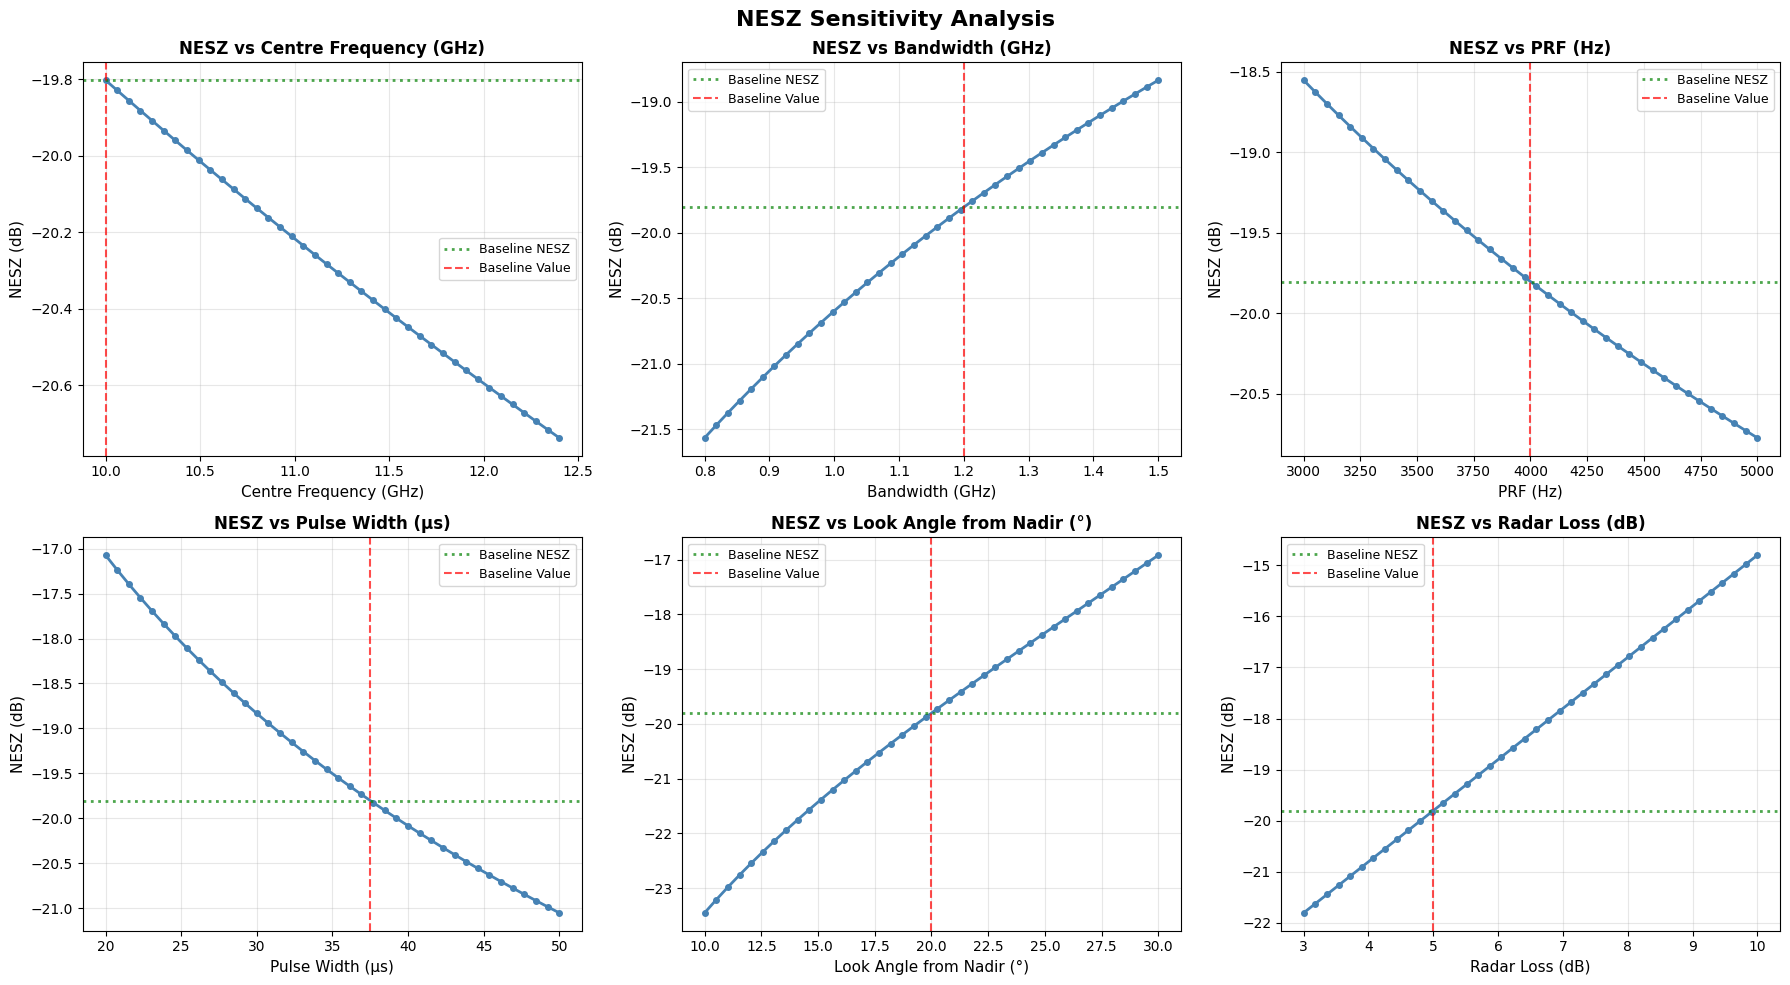

In [16]:
# Multi-panel sensitivity analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('NESZ Sensitivity Analysis', fontsize=16, fontweight='bold')

# Define parameter ranges
params = {
    'centre_frequency_hz': (np.linspace(10e9, 12.4e9, 40), 'Centre Frequency (GHz)', 1e9),
    'bandwidth_hz': (np.linspace(0.8e9, 1.5e9, 40), 'Bandwidth (GHz)', 1e9),
    'prf_hz': (np.linspace(3000, 5000, 40), 'PRF (Hz)', 1),
    'pulse_width_us': (np.linspace(20, 50, 40), 'Pulse Width (μs)', 1),
    'look_angle_from_nadir_deg': (np.linspace(10, 30, 40), 'Look Angle from Nadir (°)', 1),
    'radar_loss_db': (np.linspace(3, 10, 40), 'Radar Loss (dB)', 1),
}

# Baseline values
baseline = {
    'centre_frequency_hz': centre_frequency_hz,
    'bandwidth_hz': bandwidth_hz,
    'prf_hz': prf_hz,
    'pulse_width_us': pulse_width_us,
    'swath_m': swath_m,
    'integration_angle_deg': integration_angle_deg,
    'look_angle_from_nadir_deg': look_angle_from_nadir_deg,
    'radar_loss_db': 5.0  # Add baseline for radar_loss_db
}

# Plot each parameter
for idx, (param_name, (param_values, label, scale)) in enumerate(params.items()):
    ax = axes[idx // 3, idx % 3]
    nesz_values = []
    
    for val in param_values:
        # Create signal with current parameter value
        if param_name in ['centre_frequency_hz', 'bandwidth_hz', 'prf_hz', 'pulse_width_us']:
            signal_params = {
                'antenna': phased_array,
                'centre_frequency_hz': baseline['centre_frequency_hz'],
                'bandwidth_hz': baseline['bandwidth_hz'],
                'prf_hz': baseline['prf_hz'],
                'pulse_width_us': baseline['pulse_width_us'],
                'range_processing_loss_db': 0,
                'azimuth_processing_loss_db': 0,
                'broadening_factor_azimuth': 1.2,
                'broadening_factor_range': 1.2,
                'doppler_gain_constant': 1.5,
            }
            signal_params[param_name] = val
            test_signal = Signal(**signal_params)
            
            test_mission = SpotMission(
                swath_range_m=baseline['swath_m'],
                swath_azimuth_m=baseline['swath_m'],
                integration_angle_deg=baseline['integration_angle_deg'],
                signal=test_signal,
                satellite=satellite,
                antenna=phased_array,
                environment_parameters=environment_parameters,
            )
        elif param_name in ['look_angle_from_nadir_deg', 'radar_loss_db']:
            # Satellite parameter
            test_satellite = Satellite(
                look_angle_from_nadir_deg=val if param_name == 'look_angle_from_nadir_deg' else baseline['look_angle_from_nadir_deg'],
                platform_velocity_mps=7000.0,
                orbit_altitude_m=580000.0,
                radar_loss_db=val if param_name == 'radar_loss_db' else 5.0,
                receiver_noise_factor_db=4.0,
            )
            
            test_mission = SpotMission(
                swath_range_m=baseline['swath_m'],
                swath_azimuth_m=baseline['swath_m'],
                integration_angle_deg=baseline['integration_angle_deg'],
                signal=signal,
                satellite=test_satellite,
                antenna=phased_array,
                environment_parameters=environment_parameters,
            )
        else:
            # Mission-level parameters (swath_m, integration_angle_deg)
            mission_params = {
                'swath_m': baseline['swath_m'],
                'integration_angle_deg': baseline['integration_angle_deg']
            }
            mission_params[param_name] = val
            
            test_mission = SpotMission(
                **mission_params,
                signal=signal,
                satellite=satellite,
                phased_array=phased_array,
                environment_parameters=environment_parameters,
            )
        
        nesz_values.append(test_mission.nes0_db)
    
    # Plot
    ax.plot(param_values / scale, nesz_values, 'o-', linewidth=2, markersize=4, color='steelblue')
    ax.axhline(baseline_nesz, color='green', linestyle=':', linewidth=2, label='Baseline NESZ', alpha=0.7)
    ax.axvline(baseline[param_name] / scale, color='red', linestyle='--', alpha=0.7, label='Baseline Value')
    ax.set_xlabel(label, fontsize=11)
    ax.set_ylabel('NESZ (dB)', fontsize=11)
    ax.set_title(f'NESZ vs {label}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

Recall from <i>Eqn (35)</i> from the literature,
$$
NESZ = \dfrac{2\left(4\pi\right)^3R^3v_x\cos{\psi_g}\left(kTF_N\right)L_{radar}L_{atmos}L_rL_a}{P_{avg}G_A^2\lambda^3\rho_r a_{wa}}
$$
TODO: patch antenna beam pattern??

We know that ${G_a} = \dfrac{4\pi A_e}{\lambda^2}$,
$$
NESZ = \dfrac{2\left(4\pi\right)^3R^3v_x\cos{\psi_g}\left(kTF_N\right)\lambda L_{radar}L_{atmos}L_rL_a}{P_{avg}\left(4\pi A_e\right)^2\rho_r a_{wa}}
= \dfrac{2\left(4\pi\right)^3R^3v_x\cos{\psi_g}\left(kTF_N\right)\left(\dfrac{c}{f}\right)L_{radar}L_{atmos}L_rL_a}{P_{avg}\left(4\pi A_e\right)^2\rho_r a_{wa}}
$$

This yields us the following updated NESZ formula,
$$
NESZ = \dfrac{2\left(4\pi\right)^3R^3v_x\cos{\psi_g}\left(kTF_N\right)cL_{radar}L_{atmos}L_rL_a}{P_{avg}f\left(4\pi A_e\right)^2\rho_r a_{wa}}
$$
The above formula shows that NESZ is proportional to $\dfrac{1}{f}$.

We further transform the above equation to <i>Eqn (37)</i>:
$$
NESZ = \dfrac{256\pi^3kT}{c}\left(R^3v_x\cos{\psi_g} \right)\left( \dfrac{B_TF_NL_{radar}L_{atmos}}{P_{avg}G_A^2\lambda^3} \right) \left( \dfrac{L_rL_a}{a_{wr}a_{wa}} \right)
$$

$(R^3v_x\cos{\psi_g})$ represents the geometry and environment constraints, the mission defines these parameters.

$\left(  \dfrac{B_TF_NL_{radar}L_{atmos}}{P_{avg}G_A^2\lambda^3} \right)$ represents radar hardware limitations. 
- Selected based on the geometry and environment constraints but at the same time needs to take into account the radar signal processing needs. 
- Parameters that are usually changed are $\lambda$, and $P_{avg}$. 
- $P_{avg}$ is usually limited by some maximum $P_t$ and duty cycle.
- $B_T$ is nominally the transmitted signal bandwidth, but may be limited by receiver bandwidth.
- $F_N$ is the noise figure for the receiver based on its construction.
- $L_{radar}$ embodies the hardware system losses. 
- $L_{atmos}$ is a function of geometry and $\lambda$, with the weather model specified and geometry, we can control $L_{atmos}$ by selecting $\lambda$

$\left( \dfrac{L_rL_a}{a_{wr}a_{wa}} \right)$ deals with signal processing. 
- $a_{wr}$ and $a_{wa}$ are the broadening factors for range and azimuth respectively.
- $L_r$ and $L_a$ are the gain losses from windowing. 

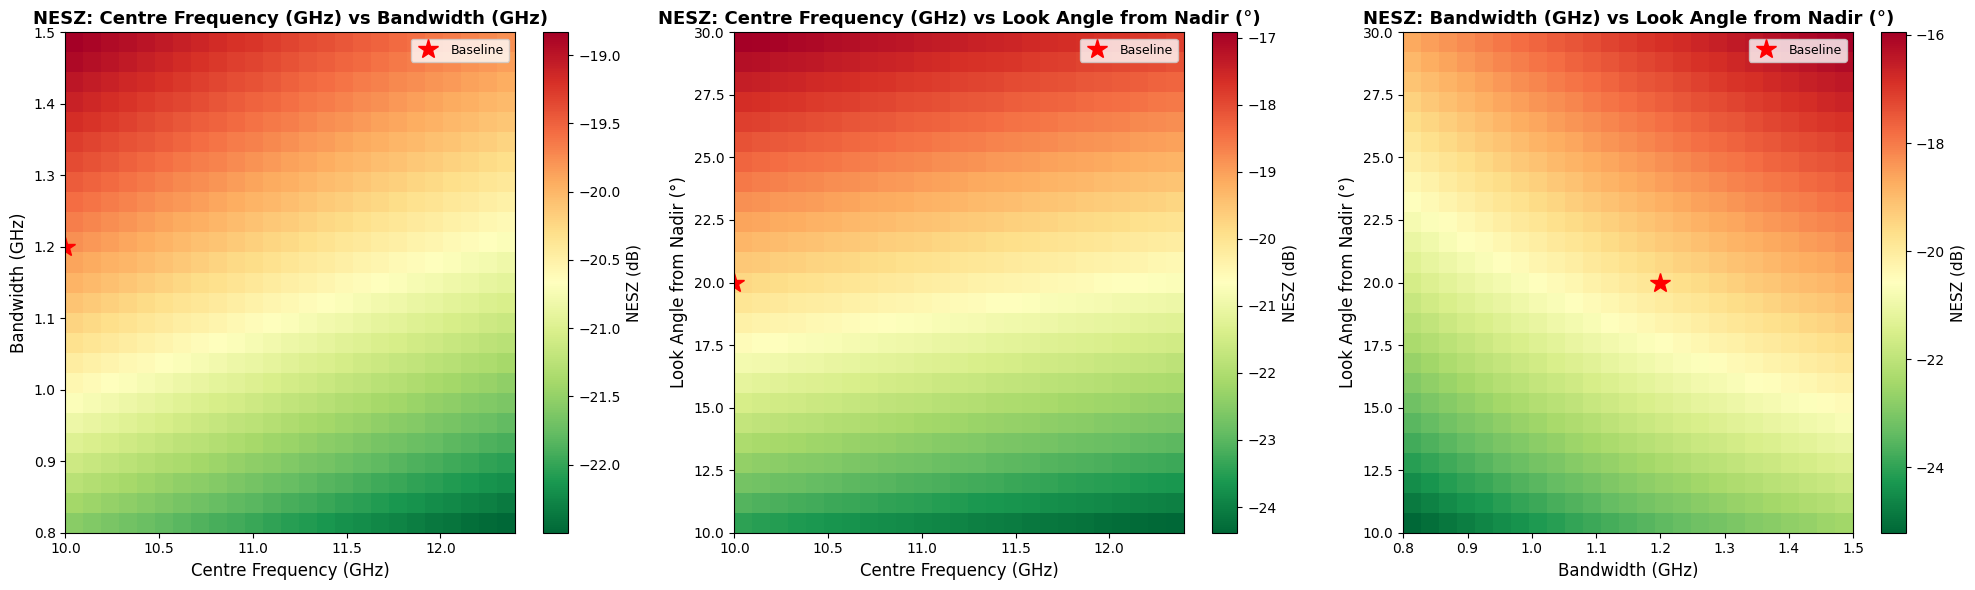

In [18]:
# Heatmap: Frequency vs Bandwidth interaction
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Define three interesting parameter pairs
param_pairs = [
    ('centre_frequency_hz', 'bandwidth_hz', 
     np.linspace(10e9, 12.4e9, 25), np.linspace(0.8e9, 1.5e9, 25),
     'Centre Frequency (GHz)', 'Bandwidth (GHz)', 1e9, 1e9),
    
    ('centre_frequency_hz', 'look_angle_from_nadir_deg',
     np.linspace(10e9, 12.4e9, 25), np.linspace(10, 30, 25),
     'Centre Frequency (GHz)', 'Look Angle from Nadir (°)', 1e9, 1),
    
    ('bandwidth_hz', 'look_angle_from_nadir_deg',
     np.linspace(0.8e9, 1.5e9, 25), np.linspace(10, 30, 25),
     'Bandwidth (GHz)', 'Look Angle from Nadir (°)', 1e9, 1)
]

for ax_idx, (param1, param2, vals1, vals2, label1, label2, scale1, scale2) in enumerate(param_pairs):
    ax = axes[ax_idx]
    nesz_grid = np.zeros((len(vals2), len(vals1)))
    
    for i, val2 in enumerate(vals2):
        for j, val1 in enumerate(vals1):
            # Create signal with current parameter value
            signal_params = {
                'antenna': phased_array,
                'centre_frequency_hz': baseline['centre_frequency_hz'],
                'bandwidth_hz': baseline['bandwidth_hz'],
                'prf_hz': baseline['prf_hz'],
                'pulse_width_us': baseline['pulse_width_us'],
                'range_processing_loss_db': 0,
                'azimuth_processing_loss_db': 0,
                'broadening_factor_azimuth': 1.2,
                'broadening_factor_range': 1.2,
                'doppler_gain_constant': 1.5,
            }
            
            # Update signal parameters if param1 or param2 is signal-related
            if param1 in signal_params:
                signal_params[param1] = val1
            if param2 in signal_params:
                signal_params[param2] = val2
            
            test_signal = Signal(**signal_params)
            
            # Create satellite with look_angle_from_nadir_deg if needed
            if param1 == 'look_angle_from_nadir_deg' or param2 == 'look_angle_from_nadir_deg':
                look_angle = val1 if param1 == 'look_angle_from_nadir_deg' else val2
                test_satellite = Satellite(
                    look_angle_from_nadir_deg=look_angle,
                    platform_velocity_mps=7000.0,
                    orbit_altitude_m=580000.0,
                    radar_loss_db=5.0,
                    receiver_noise_factor_db=4.0,
                )
            else:
                test_satellite = satellite
            
            test_mission = SpotMission(
                swath_range_m=baseline['swath_m'],
                swath_azimuth_m=baseline['swath_m'],
                integration_angle_deg=baseline['integration_angle_deg'],
                signal=test_signal,
                satellite=test_satellite,
                antenna=phased_array,
                environment_parameters=environment_parameters,
            )
            
            nesz_grid[i, j] = test_mission.nes0_db
    
    # Plot heatmap
    im = ax.imshow(nesz_grid, 
                   extent=[vals1[0]/scale1, vals1[-1]/scale1, vals2[0]/scale2, vals2[-1]/scale2],
                   aspect='auto', origin='lower', cmap='RdYlGn_r')
    
    # Mark baseline
    baseline_val1 = baseline.get(param1, look_angle_from_nadir_deg)
    baseline_val2 = baseline.get(param2, look_angle_from_nadir_deg)
    ax.plot(baseline_val1/scale1, baseline_val2/scale2, 'r*', markersize=15, label='Baseline')
    
    ax.set_xlabel(label1, fontsize=12)
    ax.set_ylabel(label2, fontsize=12)
    ax.set_title(f'NESZ: {label1} vs {label2}', fontsize=13, fontweight='bold')
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('NESZ (dB)', fontsize=11)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()